___

<center><h1>Bank Churn Analysis</h1></center>

___

<center><h2>I Cloud 7</h2></center><br>
<center> Data Scientist Jr. Assessment </center>

___
<p></p>
<center style="color: #AA6373; font-weight: 400;"><strong>Presented by:</strong></center>
<center style="color: #AA6373; font-weight: 400;">Jorge Forero L.</center>

<center>September 2024</center>
<p></p>

In [1]:
# Common Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler

# Modelling
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Testing and Evaluation
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV
import unittest

In [2]:
file_path = '../src/Bank+Customer+Churn/Bank_Churn.csv'

# Load the CSV file into a DataFrame, handling potential errors
try:
    # Load the CSV with specified encoding and handle any bad lines
    df_bank_churn = pd.read_csv(file_path, encoding='ISO-8859-1', on_bad_lines='skip')
    print("Data loaded successfully. Displaying the first 5 rows:")
    print(df_bank_churn.head())

    # Print the column names
    print("\nColumn names:")
    print(df_bank_churn.columns)

except FileNotFoundError:
    print("Error: File not found at the specified path.")
except pd.errors.ParserError:
    print("Error: Could not parse the CSV file. Please check the file format.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Data loaded successfully. Displaying the first 5 rows:
   CustomerId   Surname  CreditScore Geography  Gender  Age  Tenure  \
0    15634602  Hargrave          619    France  Female   42       2   
1    15647311      Hill          608     Spain  Female   41       1   
2    15619304      Onio          502    France  Female   42       8   
3    15701354      Boni          699    France  Female   39       1   
4    15737888  Mitchell          850     Spain  Female   43       2   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              1          1               1        101348.88   
1   83807.86              1          0               1        112542.58   
2  159660.80              3          1               0        113931.57   
3       0.00              2          0               0         93826.63   
4  125510.82              1          1               1         79084.10   

   Exited  
0       1  
1       0  
2       1  
3       0  
4      

## Exploratory Data Analysis

#### Volume of Data

In [3]:
# Count the number of records (rows) and features (columns)
num_records = len(df_bank_churn)
num_features = len(df_bank_churn.columns)

# Print the size of the dataset
print(f"The dataset has {num_records} records and {num_features} features.")

The dataset has 10000 records and 13 features.


In [4]:
# Basic data exploration
print("Shape of the dataset:", df_bank_churn.shape)
print("Data types:", df_bank_churn.dtypes)
print("Missing values in each column:", df_bank_churn.isnull().sum())
df_bank_churn.describe()

Shape of the dataset: (10000, 13)
Data types: CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object
Missing values in each column: CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


#### Data Cleaning

##### Fixing Data Types

In [5]:
# Change the data types of the specified columns to Boolean because of the description of each
df_bank_churn['HasCrCard'] = df_bank_churn['HasCrCard'].astype(bool)
df_bank_churn['IsActiveMember'] = df_bank_churn['IsActiveMember'].astype(bool)

print(df_bank_churn[['HasCrCard', 'IsActiveMember']].dtypes)

HasCrCard         bool
IsActiveMember    bool
dtype: object


In [6]:
# List of columns to drop
columns_to_drop = ['Surname', 'Gender', 'CustomerId']

df_cleaned = df_bank_churn.drop(columns=columns_to_drop)

df_cleaned.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,42,2,0.00,1,True,True,101348.88,1
1,608,Spain,41,1,83807.86,1,False,True,112542.58,0
2,502,France,42,8,159660.80,3,True,False,113931.57,1
3,699,France,39,1,0.00,2,False,False,93826.63,0
4,850,Spain,43,2,125510.82,1,True,True,79084.10,0


#### Categorical Feature Summary

Here we assess the distribution of values across categorical features 

In [7]:
# Set the count to distinct values in each categorical feature
for col_name in ['Geography', 'NumOfProducts']:
    print(f"\nDistinct counts for {col_name}:")
    print(df_cleaned[col_name].value_counts())



Distinct counts for Geography:
Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

Distinct counts for NumOfProducts:
NumOfProducts
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64


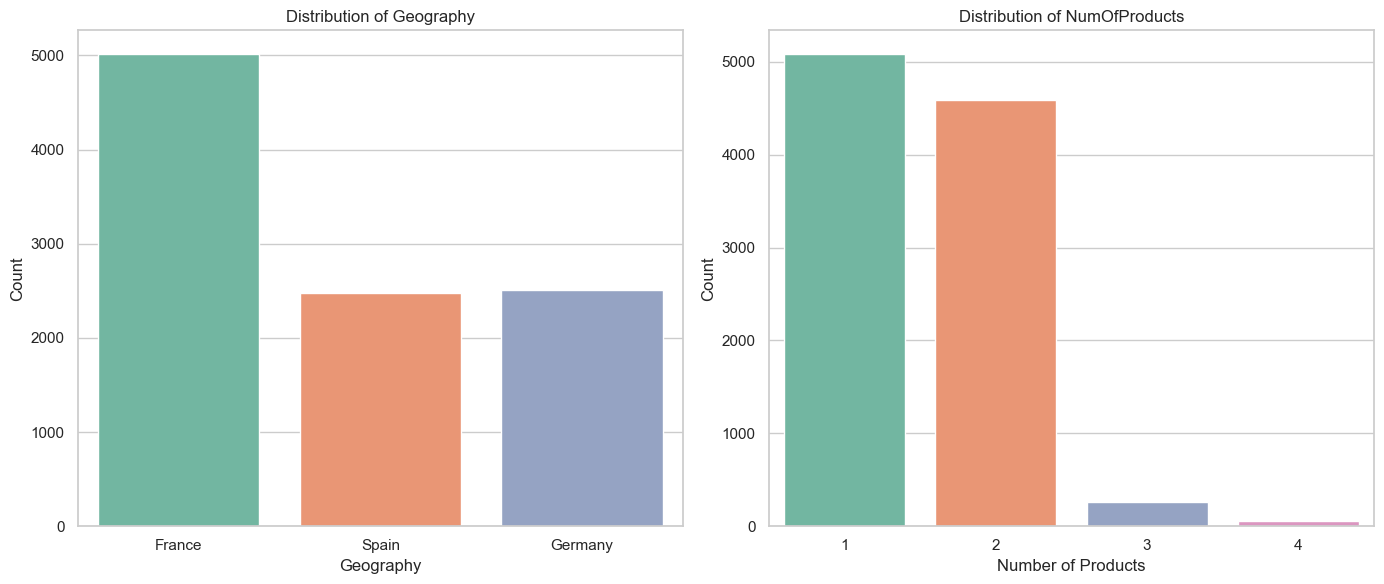

In [8]:
sns.set(style="whitegrid")

# Create two subplots - one for 'Geography' and one for 'NumOfProducts'
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the distribution of 'Geography'
sns.countplot(ax=axes[0], data=df_bank_churn, x='Geography', hue='Geography', palette='Set2', legend=False)
axes[0].set_title('Distribution of Geography')
axes[0].set_xlabel('Geography')
axes[0].set_ylabel('Count')

# Plot the distribution of 'NumOfProducts'
sns.countplot(ax=axes[1], data=df_bank_churn, x='NumOfProducts', hue='NumOfProducts', palette='Set2', legend=False)
axes[1].set_title('Distribution of NumOfProducts')
axes[1].set_xlabel('Number of Products')
axes[1].set_ylabel('Count')

# Adjust the layout
plt.tight_layout()

# Display the plots
plt.show()

#### Class Imbalance Analysis

Here we determine the distribution of the target feature "Exited" where we want to assess class imbalance that is a critical factor to implement Machine Learning Models

In [9]:
# Count the number of occurrences for each class in 'Late_delivery_risk'
exited_counts = df_cleaned['Exited'].value_counts()

# Display the counts
print("Count of occurrences for each class in 'Exited':")
print(exited_counts)

Count of occurrences for each class in 'Exited':
Exited
0    7963
1    2037
Name: count, dtype: int64


#### Region Specific Churn Analysis

If we train one global model it might not capture the unique patterns in each country. Training separate models for France, Spain and Germany would likely improve the accuracy of the predictions and allow us to identify features that are most important in each region.

In [10]:
# Split the dataset by country
df_france = df_cleaned[df_bank_churn['Geography'] == 'France']
df_spain = df_cleaned[df_bank_churn['Geography'] == 'Spain']
df_germany = df_cleaned[df_bank_churn['Geography'] == 'Germany']

# Verify the split
print("France dataset size:", df_france.shape)
print("Spain dataset size:", df_spain.shape)
print("Germany dataset size:", df_germany.shape)

France dataset size: (5014, 10)
Spain dataset size: (2477, 10)
Germany dataset size: (2509, 10)


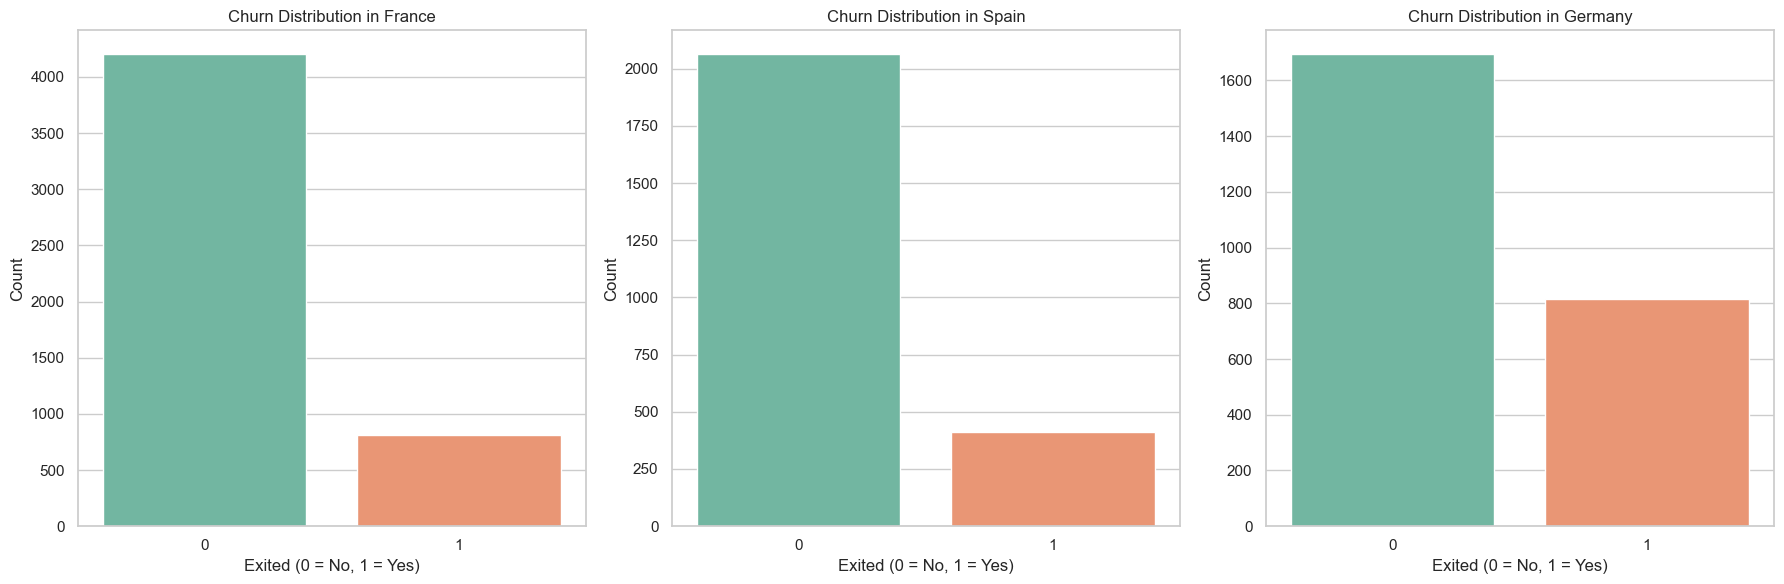

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the plots
sns.set(style="whitegrid")

# Create a figure with 3 subplots (one for each country)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# France
sns.countplot(ax=axes[0], data=df_france, x='Exited', hue='Exited', palette='Set2', legend=False)
axes[0].set_title('Churn Distribution in France')
axes[0].set_xlabel('Exited (0 = No, 1 = Yes)')
axes[0].set_ylabel('Count')

# Spain
sns.countplot(ax=axes[1], data=df_spain, x='Exited', hue='Exited', palette='Set2', legend=False)
axes[1].set_title('Churn Distribution in Spain')
axes[1].set_xlabel('Exited (0 = No, 1 = Yes)')
axes[1].set_ylabel('Count')

# Germany
sns.countplot(ax=axes[2], data=df_germany, x='Exited', hue='Exited', palette='Set2', legend=False)
axes[2].set_title('Churn Distribution in Germany')
axes[2].set_xlabel('Exited (0 = No, 1 = Yes)')
axes[2].set_ylabel('Count')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

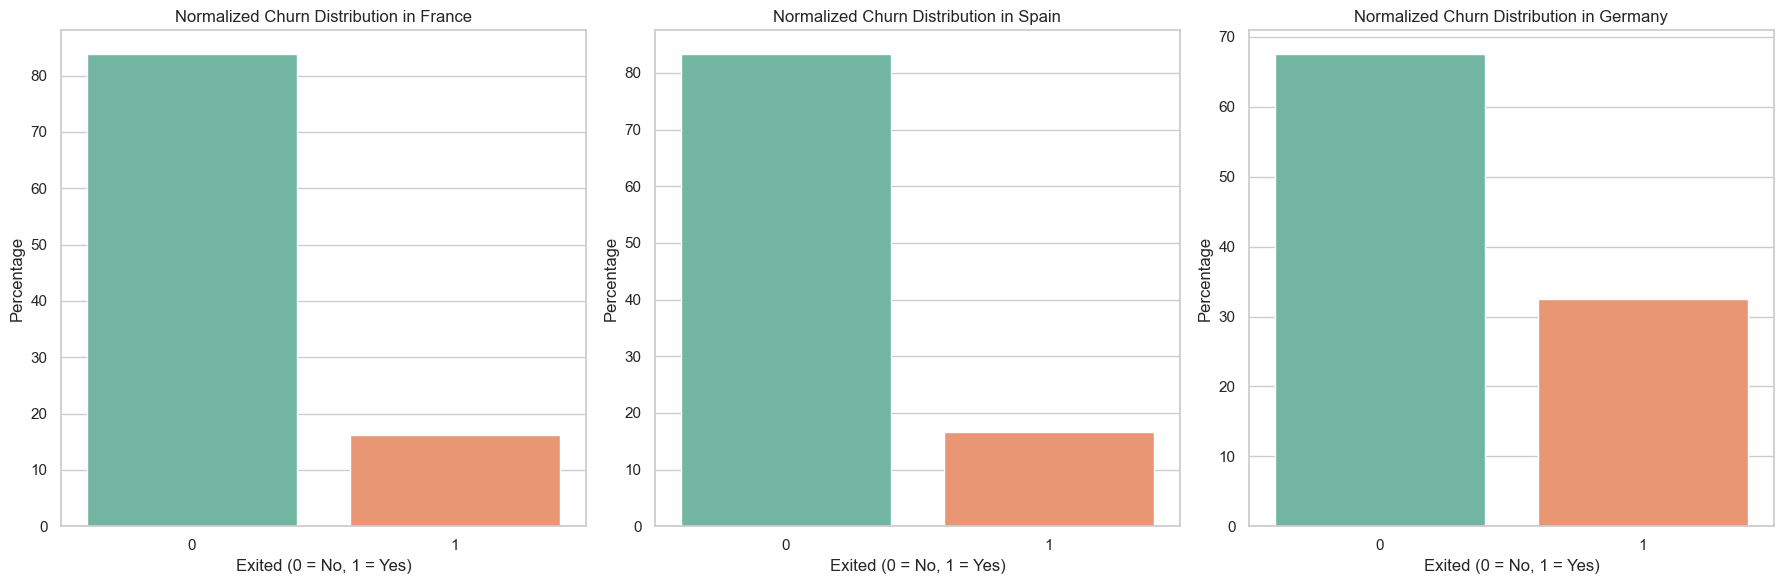

In [12]:
# Function to normalize churn
def normalize_churn(df):
    churn_counts = df['Exited'].value_counts(normalize=True) * 100
    return churn_counts

# Normalize churn for each country
churn_france = normalize_churn(df_france)
churn_spain = normalize_churn(df_spain)
churn_germany = normalize_churn(df_germany)

# Plot the normalized churn distribution for each country
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for France
sns.barplot(x=churn_france.index, y=churn_france.values, ax=axes[0], hue=churn_france.index, palette='Set2', legend=False)
axes[0].set_title('Normalized Churn Distribution in France')
axes[0].set_xlabel('Exited (0 = No, 1 = Yes)')
axes[0].set_ylabel('Percentage')

# Plot for Spain
sns.barplot(x=churn_spain.index, y=churn_spain.values, ax=axes[1], hue=churn_spain.index, palette='Set2', legend=False)
axes[1].set_title('Normalized Churn Distribution in Spain')
axes[1].set_xlabel('Exited (0 = No, 1 = Yes)')
axes[1].set_ylabel('Percentage')

# Plot for Germany
sns.barplot(x=churn_germany.index, y=churn_germany.values, ax=axes[2], hue=churn_germany.index, palette='Set2', legend=False)
axes[2].set_title('Normalized Churn Distribution in Germany')
axes[2].set_xlabel('Exited (0 = No, 1 = Yes)')
axes[2].set_ylabel('Percentage')

# Adjust layout
plt.tight_layout()
plt.show()

#### Feature Selection
The dataset is conformed by 10 features after dropping the ones that could affect the analysis or that are not most relevant

In [13]:
print(df_cleaned.columns)

Index(['CreditScore', 'Geography', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')


In [14]:
features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

# Define target (Exited)
target = 'Exited'

# Select features and target for France
X_france = df_france[features]
y_france = df_france[target]

# Select features and target for Spain
X_spain = df_spain[features]
y_spain = df_spain[target]

# Select features and target for Germany
X_germany = df_germany[features]
y_germany = df_germany[target]

# Verify the shape of the selected data
print("France selected data shape:", X_france.shape)
print("Spain selected data shape:", X_spain.shape)
print("Germany selected data shape:", X_germany.shape)

France selected data shape: (5014, 8)
Spain selected data shape: (2477, 8)
Germany selected data shape: (2509, 8)


#### One Hot Encoding

In [15]:
# One-hot encode the 'NumOfProducts' column
X_france = pd.get_dummies(df_france[features], columns=['NumOfProducts'], drop_first=True)
X_spain = pd.get_dummies(df_spain[features], columns=['NumOfProducts'], drop_first=True)
X_germany = pd.get_dummies(df_germany[features], columns=['NumOfProducts'], drop_first=True)

# The target remains the same
y_france = df_france[target]
y_spain = df_spain[target]
y_germany = df_germany[target]

# Verify the shape of the selected data after one-hot encoding
print("France selected data shape after encoding:", X_france.shape)
print("Spain selected data shape after encoding:", X_spain.shape)
print("Germany selected data shape after encoding:", X_germany.shape)

France selected data shape after encoding: (5014, 10)
Spain selected data shape after encoding: (2477, 10)
Germany selected data shape after encoding: (2509, 10)


### Modelling
Here we select the Random Forest, SVM, and Logistic Regression to make the analysis

### Undersampled Dataset

In [26]:
# Function to perform undersampling
def undersample_data(X, y):
    undersampler = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(X, y)
    return X_resampled, y_resampled
 
# France dataset
X_france_resampled, y_france_resampled = undersample_data(X_france, y_france)
print("France data shape after undersampling:", X_france_resampled.shape)
print("France target shape after undersampling:", y_france_resampled.shape)

# Spain dataset
X_spain_resampled, y_spain_resampled = undersample_data(X_spain, y_spain)
print("Spain data shape after undersampling:", X_spain_resampled.shape)
print("Spain target shape after undersampling:", y_spain_resampled.shape)

# Germany dataset
X_germany_resampled, y_germany_resampled = undersample_data(X_germany, y_germany)
print("Germany data shape after undersampling:", X_germany_resampled.shape)
print("Germany target shape after undersampling:", y_germany_resampled.shape)

France data shape after undersampling: (1620, 10)
France target shape after undersampling: (1620,)
Spain data shape after undersampling: (826, 10)
Spain target shape after undersampling: (826,)
Germany data shape after undersampling: (1628, 10)
Germany target shape after undersampling: (1628,)


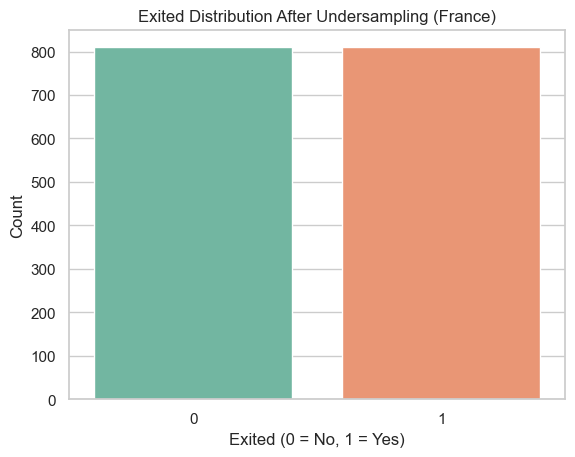

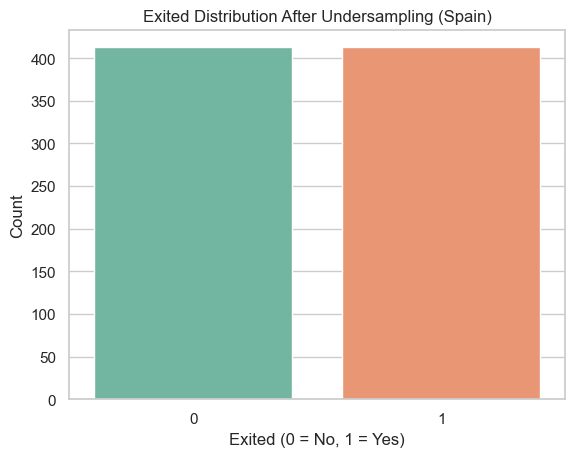

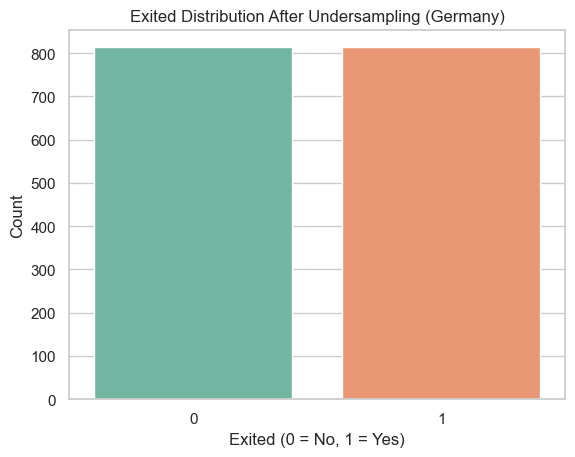

In [27]:
# Function to plot the distribution of the 'Exited' feature
def plot_exited_distribution(y_resampled, title):
    sns.countplot(x=y_resampled, palette='Set2', hue=y_resampled, legend=False)
    plt.title(title)
    plt.xlabel('Exited (0 = No, 1 = Yes)')
    plt.ylabel('Count')
    plt.show()

# Plot for France after undersampling
plot_exited_distribution(y_france_resampled, "Exited Distribution After Undersampling (France)")

# Plot for Spain after undersampling
plot_exited_distribution(y_spain_resampled, "Exited Distribution After Undersampling (Spain)")

# Plot for Germany after undersampling
plot_exited_distribution(y_germany_resampled, "Exited Distribution After Undersampling (Germany)")